In [81]:
import os, glob

import matplotlib.pyplot as plt
import pandas as pd

from astropy.nddata import CCDData
from astropy.wcs import WCS
from photutils.aperture import SkyCircularAperture, CircularAperture, aperture_photometry
from photutils.segmentation import detect_sources, make_2dgaussian_kernel
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import vstack
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.stats import sigma_clipped_stats
from astropy.convolution import convolve

import ccdproc

from util import *

# Extract the Signal

In [95]:
wcs_data_path = os.path.join(os.environ["HOME"], "instrumentation_project", "my-data", "calib", "*WCS*")
wcs_data_files = glob.glob(wcs_data_path)
wcs_data = [CustomCCDData.read(f) for f in wcs_data_files]
for ii, d in enumerate(wcs_data):
    d.mask = np.isnan(d.data)
    wcs_data[ii] = d
        

In [96]:
pos = SkyCoord(
    "05:26:38.320",
    "-17:54:54.68",
    unit=("hourangle", "deg")
)

aperture = SkyCircularAperture(pos, r=5. * u.arcsec)
apertures = [aperture.to_pixel(d.wcs) for d in wcs_data]
kuiper = Kuiper(apertures[0].r)
res = {v[0].meta["FILTER"]: aperture_photometry(*v) for v in zip(wcs_data, apertures)}

res

{'Harris-R': <QTable length=1>
   id       xcenter          ycenter         aperture_sum  
              pix              pix               adu       
 int64      float64          float64           float64     
 ----- ----------------- ---------------- -----------------
     1 689.1902316237959 705.135713586497 531131.4427429417,
 'Harris-B': <QTable length=1>
   id       xcenter           ycenter         aperture_sum  
              pix               pix               adu       
 int64      float64           float64           float64     
 ----- ----------------- ----------------- -----------------
     1 692.4297288520879 704.3353420770002 343480.7619867225,
 'Harris-V': <QTable length=1>
   id       xcenter           ycenter         aperture_sum   
              pix               pix               adu        
 int64      float64           float64           float64      
 ----- ----------------- ----------------- ------------------
     1 686.6747350069558 707.9193545467556 499030.46

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (81.65967196, -17.91519399)>
<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (81.65967196, -17.91519399)>


<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (81.65967196, -17.91519399)>
<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (81.65967196, -17.91519399)>


Text(0.5, 0.01, 'Right Ascension')

/home/nfranz/.local/lib/anaconda3/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  func(*args, **kwargs)


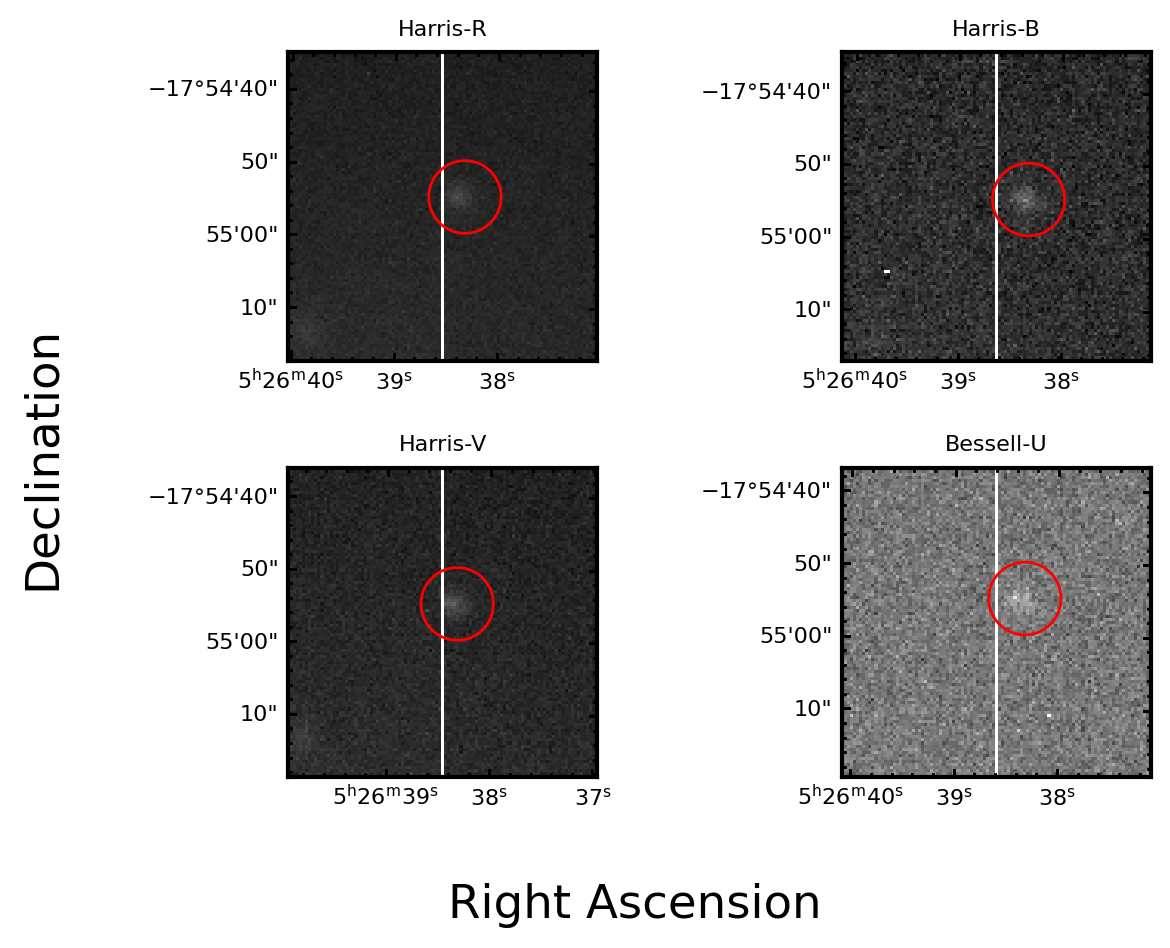

In [97]:
from matplotlib.colors import Normalize as Normalizer
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.visualization import simple_norm

fs = 8
ms = 500
fig = plt.figure()

norm_kwargs = { # these are all from playing around in ds9
    "Harris-B" : dict(vmin=775, vmax=930),
    "Harris-R" : dict(vmin=1175, vmax=1787),
    "Harris-V" : dict(vmin=1140, vmax=1532),
    "Bessell-U" : dict(vmin=186, vmax=252)
}

for ii, (img, a) in enumerate(zip(wcs_data, apertures)):

    wcs = img.wcs
    ax = fig.add_subplot(2,2,ii+1,projection=wcs) 
    
    aper = a.to_sky(wcs)
    print(aper.positions)
    
    circ = SphericalCircle(aper.positions, aper.r, edgecolor='red', facecolor='none', transform=ax.get_transform('fk5'))
    ax.add_patch(circ)
    
    ax.imshow(
        img.data,
        origin="lower",
        norm=simple_norm(
            data=img.data,
            stretch="linear",
            **norm_kwargs[img.meta["FILTER"]]
        ),
        cmap="gray"
    )
    
    for coord in ax.coords._coords:
        coord.set_auto_axislabel(False)
        coord.tick_params(labelsize=fs)
    
    # ax.scatter_coord(pos, ms, edgecolor='r', facecolor="none")
    
    ax.set_title(img.meta["FILTER"], fontsize=fs)
    
    dx = dy = 50
    midx = img.data.shape[0]//2
    midy = img.data.shape[0]//2 + 20
    xlim = (midx-dx, midx+dx)
    ylim = (midy-dy, midy+dy)
    
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    
fig.supylabel("Declination")
fig.supxlabel("Right Ascension")

In [98]:
res_to_stack = []
for k, row in res.items():
    row["FILTER"] = k
    row["aperture_sum_e"] = row["aperture_sum"] * Kuiper.gain
    row["aperture_sum_photons"] = row["aperture_sum_e"] * Kuiper.electron_to_photons
    
    res_to_stack.append(row)
    
data = vstack(res_to_stack).to_pandas()
data

,id,xcenter,ycenter,aperture_sum,FILTER,aperture_sum_e,aperture_sum_photons
0,1,689.190232,705.135714,531131.442743,Harris-R,1.646507e+06,1.646507e+06
1,1,692.429729,704.335342,343480.761987,Harris-B,1.064790e+06,1.064790e+06
2,1,686.674735,707.919355,499030.469973,Harris-V,1.546994e+06,1.546994e+06
3,1,691.207420,709.686033,91932.607575,Bessell-U,2.849911e+05,2.849911e+05


# Sky Background Noise

Put a bunch of apertures on the background of the images and median them

In [105]:
from astropy.stats import SigmaClip
from photutils.background import SExtractorBackground

bkg = SExtractorBackground(SigmaClip(sigma=3))
for img in wcs_data:
    the_bkg = bkg(img.data)
    print(the_bkg)

1246.5748182066181
805.295026534603
1192.8707577915873


218.01650235328117



def find_background(img, n=int(1e6), radius=kuiper.aperture_radius):
    
    bckgd_apertures = [
        CircularAperture(
            (
                np.random.randint(0, img.shape[0]),
                np.random.randint(0, img.shape[1])
            ), 
            radius
        ) for _ in range(n)
    ]       

    res = vstack([aperture_photometry(img, a) for a in bckgd_apertures])

    fig = plt.figure()

    wcs = img.wcs
    ax = fig.add_subplot(111,projection=wcs) 
    
    ax.imshow(img)

    for aper in bckgd_apertures:
        aper = aper.to_sky(wcs)
        circ = SphericalCircle(
                aper.positions,
                aper.r,
                edgecolor='red',
                facecolor='none',
                transform=ax.get_transform('fk5')
            )
        ax.add_patch(circ)

    return np.nanmean(res["aperture_sum"]), np.nanstd(res["aperture_sum"])    

fwhm = 3
npix = 5
all_bckgd = dict(
    FILTER = [],
    bckgd_adu = [],
    bckgd_err_adu = []
)
for img in wcs_data:
    mean, _, std = sigma_clipped_stats(img)
    
    kernel = make_2dgaussian_kernel(fwhm, size=5)
    convolved_data = convolve(img.data-mean, kernel)
    seg_img = detect_sources(
        convolved_data, 
        threshold=std, #3*std, 
        npixels=npix, 
        connectivity=8, 
        mask=np.isnan(convolved_data)
    )

    ma = seg_img.data_ma
    inverted_ma = np.ma.array(img.data, mask=np.isnan(img.data)+~ma.mask)
    img.data = inverted_ma.filled(0)
    
    bckgd, backgd_err = find_background(img, n=100)

    all_bckgd["FILTER"].append(img.header["FILTER"])
    all_bckgd["bckgd_adu"].append(bckgd.value)
    all_bckgd["bckgd_err_adu"].append(backgd_err.value)

bckgd_df = pd.DataFrame(all_bckgd)
bckgd_df["bckgd_e"] = bckgd_df.bckgd_adu*Kuiper.gain
bckgd_df["bckgd_err_e"] = bckgd_df.bckgd_err_adu*Kuiper.gain
bckgd_df["bckgd_photons"] = bckgd_df.bckgd_e*Kuiper.electron_to_photons
bckgd_df["bckgd_err_photons"] = bckgd_df.bckgd_err_e*Kuiper.electron_to_photons

data = pd.merge(data, bckgd_df, on="FILTER")

data

# Dark Noise

Estimate the dark noise by reading in the darks and then summing all of the values in them

In [54]:
dark_combined = CustomCCDData.read(
    os.path.join(os.environ["HOME"], "instrumentation_project", "my-data", "COMBINED_DARKS_FIFTY.fits")
)

dark_noise_adu = np.nanstd(dark_combined.data)

data["dark_noise_adu"] = dark_noise_adu
data["dark_noise_e"] = Kuiper.gain*dark_noise_adu

data

,id,xcenter,ycenter,aperture_sum,FILTER,aperture_sum_e,aperture_sum_photons,bckgd_adu,bckgd_err_adu,bckgd_e,bckgd_err_e,bckgd_photons,bckgd_err_photons,dark_noise_adu,dark_noise_e
0,1,689.190232,705.135714,531131.442743,Harris-R,1.646507e+06,1.646507e+06,544033.555623,13423.782012,1.686504e+06,41613.724236,1.686504e+06,41613.724236,22.669084,70.274159
1,1,692.429729,704.335342,343480.761987,Harris-B,1.064790e+06,1.064790e+06,350970.692354,7221.401635,1.088009e+06,22386.345067,1.088009e+06,22386.345067,22.669084,70.274159
2,1,686.674735,707.919355,499030.469973,Harris-V,1.546994e+06,1.546994e+06,516545.581149,24975.214783,1.601291e+06,77423.165828,1.601291e+06,77423.165828,22.669084,70.274159
3,1,691.207420,709.686033,91932.607575,Bessell-U,2.849911e+05,2.849911e+05,94397.766122,6402.551379,2.926331e+05,19847.909275,2.926331e+05,19847.909275,22.669084,70.274159


# Read Noise

Estimate the read noise from the bias images

In [55]:
bias_combined = CustomCCDData.read(
    os.path.join(os.environ["HOME"], "instrumentation_project", "my-data", "COMBINED_BIAS.fits")
)

files = ReductionFiles(os.path.join(os.environ["HOME"], "instrumentation_project", "my-data"))
files.read_and_organize("AT2024wsd")
bias_data = [CustomCCDData.read(bias_file) for bias_file in files.bias_files["none"]]

rn = []
for _ in range(100):
    rng_choice = np.random.choice(len(bias_data))
    read_noise = ccdproc.subtract_bias(bias_combined, bias_data[rng_choice])    
    rn.append(read_noise)
    
read_noise_adu = np.nanstd(rn)

data["read_noise_adu"] = read_noise_adu
data["read_noise_e"] = Kuiper.gain * read_noise_adu

data

,id,xcenter,ycenter,aperture_sum,FILTER,aperture_sum_e,aperture_sum_photons,bckgd_adu,bckgd_err_adu,bckgd_e,bckgd_err_e,bckgd_photons,bckgd_err_photons,dark_noise_adu,dark_noise_e,read_noise_adu,read_noise_e
0,1,689.190232,705.135714,531131.442743,Harris-R,1.646507e+06,1.646507e+06,544033.555623,13423.782012,1.686504e+06,41613.724236,1.686504e+06,41613.724236,22.669084,70.274159,3.265159,10.121992
1,1,692.429729,704.335342,343480.761987,Harris-B,1.064790e+06,1.064790e+06,350970.692354,7221.401635,1.088009e+06,22386.345067,1.088009e+06,22386.345067,22.669084,70.274159,3.265159,10.121992
2,1,686.674735,707.919355,499030.469973,Harris-V,1.546994e+06,1.546994e+06,516545.581149,24975.214783,1.601291e+06,77423.165828,1.601291e+06,77423.165828,22.669084,70.274159,3.265159,10.121992
3,1,691.207420,709.686033,91932.607575,Bessell-U,2.849911e+05,2.849911e+05,94397.766122,6402.551379,2.926331e+05,19847.909275,2.926331e+05,19847.909275,22.669084,70.274159,3.265159,10.121992


# Background Subtraction

Now, we need to subtract the background from the signal (ie. the aperture sum) in both e and photons. This is so we can get a SNR estimate from the electrons aperture sum and then, finally, convert the aperture sum in photons to usable units.

In [56]:
data["signal_e"] = data.aperture_sum_e - data.bckgd_e
data["signal_photons"] = data.aperture_sum_photons - data.bckgd_photons

data

,id,xcenter,ycenter,aperture_sum,FILTER,aperture_sum_e,aperture_sum_photons,bckgd_adu,bckgd_err_adu,bckgd_e,bckgd_err_e,bckgd_photons,bckgd_err_photons,dark_noise_adu,dark_noise_e,read_noise_adu,read_noise_e,signal_e,signal_photons
0,1,689.190232,705.135714,531131.442743,Harris-R,1.646507e+06,1.646507e+06,544033.555623,13423.782012,1.686504e+06,41613.724236,1.686504e+06,41613.724236,22.669084,70.274159,3.265159,10.121992,-39996.549929,-39996.549929
1,1,692.429729,704.335342,343480.761987,Harris-B,1.064790e+06,1.064790e+06,350970.692354,7221.401635,1.088009e+06,22386.345067,1.088009e+06,22386.345067,22.669084,70.274159,3.265159,10.121992,-23218.784138,-23218.784138
2,1,686.674735,707.919355,499030.469973,Harris-V,1.546994e+06,1.546994e+06,516545.581149,24975.214783,1.601291e+06,77423.165828,1.601291e+06,77423.165828,22.669084,70.274159,3.265159,10.121992,-54296.844646,-54296.844646
3,1,691.207420,709.686033,91932.607575,Bessell-U,2.849911e+05,2.849911e+05,94397.766122,6402.551379,2.926331e+05,19847.909275,2.926331e+05,19847.909275,22.669084,70.274159,3.265159,10.121992,-7641.991496,-7641.991496


# Computing the Signal to Noise Ratio

In [16]:
signal = data.signal_e
noise = np.sqrt(data.signal_e + kuiper.npix*(data.read_noise_e**2 + data.dark_noise_e**2 + data.bckgd_err_e**2))

print(data.signal_e)

0   -88776.277548
1   -14636.737021
2   -84177.998603
3    -5335.697407
Name: signal_e, dtype: float64
